<a href="https://colab.research.google.com/github/ljham/drugs-generative/blob/main/_evaluate_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U python-dotenv
!pip install -U transformers
!pip install -U datasets
!pip install -U scipy
!pip install -U evaluate rouge_score
!pip install -U sacremoses
!pip install -U bitsandbytes
!pip install -U peft
!pip install -U accelerate
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
  Attempti

In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv
from datasets import load_from_disk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from sentence_transformers import SentenceTransformer

load_dotenv(find_dotenv())


True

In [4]:
PROJECT_NAME = 'drugs-generative'

try:
    from google.colab import drive
    ROOT = '/content/drive/'
    drive.mount(ROOT, force_remount=True)
    IN_COLAB = True
    BASE_FOLDER = ROOT + 'MyDrive/' + PROJECT_NAME
    DATASET_FOLDER = BASE_FOLDER

except:
    ROOT = '/kaggle'
    IN_COLAB = False
    BASE_FOLDER = os.path.join("/kaggle/working", PROJECT_NAME)
    DATASET_FOLDER = os.path.join("/kaggle/input", PROJECT_NAME)


Mounted at /content/drive/


In [25]:
# Variables Globales
path_dataset = os.path.join(BASE_FOLDER, "llamacare/dataset")

# Ruta al directorio donde guardaste el dataset
dataset = load_from_disk(path_dataset)

text_generate_t5 = os.getenv("t5")
text_generate_gpt = os.getenv("gpt")
text_generate_llama = os.getenv("llama")
HUGGING_TOKEN = os.getenv("HUGGING_TOKEN")

In [6]:
# Configurar pandas para mostrar todas las filas
pd.set_option('display.max_rows', None)

# Si también deseas mostrar todas las columnas, puedes usar:
pd.set_option('display.max_columns', None)


In [7]:
print(text_generate_t5)
print("=" * 150)
print(text_generate_gpt)
print("=" * 150)
print(text_generate_llama)
print("=" * 150)

- Last Update: 2024-10-26
- Brand Name: HealthMart Gentle Laxative
- Generic Name: BISACODYL
- Active Ingredient: BISACODYL
- Manufacturer Name: Strategic Sourcing Services LLC
- Product Type: HUMAN OTC DRUG
- Chemical Substance: Contains Bisacodyl, 10 mg.
- Indications and Usage: Relieves occasional constipation.
- Dosage and Administration: For adults and children over 12, use once daily. Consult a doctor for children under 6.
- Last Update: 2024-10-26 - Brand Name: Dragon Pain Relieving Balm - Generic Naming: BIS ACROPATHIC 1% - Active Ingredient: ISOPROPYL ALCOHOL - Manufacturer Named: Americanna Wellness, Inc - Product Type: HUMAN OTC DRUG - Chemical Substance: Active ingredients Isopropyl alcohol (50% conc.) - Indications and Usage: Uses For the temporary relief of minor aches and pains
- Last Update: 2024-10-26
- Brand Name: HealthMart Gentle Laxative
- Generic Name: BISACODYL
- Active Ingredient: BISACODYL
- Manufacturer Name: Strategic Sourcing Services LLC
- Product Type: HUM

In [30]:
def create_prompt_formats(sample):
    '''

    '''
    try:
        if(sample):
             # Lista de campos a procesar: campo en el dataset, nombre a mostrar, pregunta asociada
            fields = [
                ("last_updated", "- Last Update", None),
                #("id", "- Id Product", None),
                ("brand_name", "- Brand Name", "What is the brand name of the medication?"),
                ("generic_name", "- Generic Name", "What is the generic name of the medication?"),
                ("description", "- Description", None),
                ("substance_name", "- Active Ingredient", "What is the active ingredient of the medication?"),
                ("manufacturer_name", "- Manufacturer Name", "Who is the manufacturer of the medication?"),
                ("product_type", "- Product Type", None),
                ("route", "- Route of Administration", None),
                ("adverse_reactions", "- Adverse Reactions", "What adverse reactions are associated with this medication?"),
                ("controlled_substance", "- Controlled Substance", None),
                ("active_ingredient", "- Chemical Substance", None),
                ("indications_and_usage", "- Indications and Usage", "What is this medication used for?"),
                ("contraindications", "- Contraindications", "What are the contraindications of the medication?"),
                ("dosage_and_administration", "- Dosage and Administration", "What is the recommended dosage for this medication?"),
                #("warnings", "Warnings", "- What warnings are associated with this medication?"),
                #("precautions", "- Precautions", None)
            ]
            drugs = []
            questions = []

            # Procesar los campos y construir las secciones de descripción y preguntas/respuestas
            for field, label_name, question_text in fields:
                field_value = sample.get(field)
                if field_value:
                    # Añadir al bloque de descripción del medicamento en formato simple
                    drugs.append(f'{label_name}: {field_value}')
                    # Si hay una pregunta asociada al campo, añadirla también
                    if question_text:
                        questions.append(f'Question: {question_text}\nAnswer: {field_value}')

            # Mensaje del sistema con el prompt mejorado
            system_message = f"""You are a helpful Medical Assistant. Your task is to generate descriptions of medications or respond to questions related to them, depending on the user's request.
            If the user asks a **direct question about the medication**, answer based on the provided information and the medication's context.
            Please use only the available information in the provided context. Do not fabricate information. If a field lacks data, state "No specific information available.
            """
            description = "\n".join(drugs)

            # Agregar las preguntas si hay
            if questions:
                questions_block = "\n".join(questions)

            sample = description
        #{questions_block if(questions_block!= '') else ''}
    except Exception as ex:
        raise Exception(f'Ocurrió un error inesperado al cargar el prompt [line: {ex.__traceback__.tb_lineno}] - {ex}')

    return sample


# Función para calcular la cantidad de palabras en cada sección
def word_count(descripcion):
    return len(descripcion.split())


# Function to calculate cosine similarity
def calculate_similarity(real_text, generated_text):
    vectorizer = TfidfVectorizer()
    combined_text = [real_text, generated_text]
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]


# Función para calcular la similitud de coseno entre listas de descripciones
def compute_cosine_similarities(descriptions_real, descriptions_generated):
    # Generar embeddings para las descripciones reales y generadas
    real_embeddings = model.encode(descriptions_real)
    generated_embeddings = model.encode(descriptions_generated)

    # Calcular similitud de coseno para cada par de descripciones real-generada
    similarities = [
        cosine_similarity(real.reshape(1, -1), generated.reshape(1, -1))[0][0]
        for real, generated in zip(real_embeddings, generated_embeddings)
    ]
    return similarities


# Plot similarity scores in individual bar charts
def plot_individual_similarity(model_name, similarity_score):
    plt.figure(figsize=(6, 5))
    plt.bar(["Descripción Real", "Descripción Generada"], [1.0, similarity_score], color=["skyblue", "lightgreen"], edgecolor="black", linewidth=1.5)
    plt.ylim(0, 1)
    plt.ylabel("Similitud Coseno", fontsize=12, fontweight='bold')
    plt.title(f"Real vs Prediccion [Modelo : {model_name}]", fontsize=14, fontweight='bold')
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(fontsize=11, fontweight='bold')
    plt.yticks(fontsize=11)
    plt.text(-0.1, 1.02, "1.0", ha='center', va='bottom', color="skyblue", fontweight="bold", fontsize=12)
    plt.text(0.9, similarity_score + 0.02, f"{similarity_score:.2f}", ha='center', va='bottom', color="lightgreen", fontweight="bold", fontsize=12)
    plt.show()

# Calcular la similitud coseno para el texto generado por cada modelo y graficarla
def evaluate_and_plot_similarities(prompt, generated_texts):
    # Calcular similitudes
    similarities = {model: calculate_similarity(prompt, text) for model, text in generated_texts.items()}

    # Graficar todas las similitudes en un mismo gráfico
    plot_all_similarities(similarities)

    # Opcional: Imprimir cada puntuación de similitud
    for model, score in similarities.items():
        print(f"Modelo: {model}, Similitud Coseno: {score:.2f}")

    return similarities


# Función para graficar las similitudes de todos los modelos en una sola gráfica
def plot_all_similarities(similarity_scores):
    plt.figure(figsize=(8, 6))  # Tamaño de la figura para mejor legibilidad

    # Nombres de los modelos y sus puntuaciones de similitud
    labels = ["Real", "ClinicalT5", "Biogpt", "Llamacare"]
    scores = [1.0] + [similarity_scores.get(model, 0) for model in ["clinicalt5", "biogpt", "llamacare"]]

    # Configuración del gráfico de barras
    colors = ["#1c2e4a", "#3a5073", "#5e82a3", "#a0c4e8"]
    plt.bar(labels, scores, color=colors, edgecolor="black", linewidth=1.2)
    plt.ylim(0, 1)  # Rango del eje Y fijo para la similitud coseno
    plt.ylabel("Similitud Coseno", fontsize=12, fontweight='bold')
    plt.title("Comparativa Similitud Coseno", fontsize=14, fontweight='bold')
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.xticks(fontsize=11, fontweight='bold')
    plt.yticks(fontsize=11)

    # Mostrar los valores de similitud sobre cada barra
    for i, score in enumerate(scores):
        plt.text(i, score + 0.02, f"{score:.2f}", ha='center', va='bottom', color=colors[i], fontweight="bold", fontsize=11)

    plt.show()


# Function to calculate word length distribution
def word_length_distribution(text):
    words = [len(word) for word in text.split()]
    return Counter(words)

# Plot grouped bar chart for word length distribution comparison
def plot_grouped_bar_distribution(model_name, real_lengths, model_lengths):
    max_length = max(max(real_lengths.keys()), max(model_lengths.keys()))
    real_freqs = [real_lengths.get(i, 0) for i in range(1, max_length + 1)]
    model_freqs = [model_lengths.get(i, 0) for i in range(1, max_length + 1)]

    x = range(1, max_length + 1)
    bar_width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar([i - bar_width/2 for i in x], real_freqs, bar_width, color="#5e82a3", label="Descripción Real")
    plt.bar([i + bar_width/2 for i in x], model_freqs, bar_width, color="#a0c4e8", label=f"Descripción Generada")
    plt.xlabel("Longitud  de Palabras")
    plt.ylabel("Frecuencia")
    plt.title(f" Longitud de Palabras Distribution: Real vs Predicción - Modelo [{model_name}]")
    plt.xticks(x)
    plt.legend(loc="upper right")
    plt.show()



In [9]:
index = 68

sample = dataset['validation'][index]
prompt = create_prompt_formats(sample)
print(prompt)

- Last Update: 2024-10-26
- Brand Name: HealthMart Gentle Laxative
- Generic Name: BISACODYL
- Active Ingredient: BISACODYL
- Manufacturer Name: Strategic Sourcing Services LLC
- Product Type: HUMAN OTC DRUG
- Chemical Substance: Active ingredient Bisacodyl USP, 10 mg
- Indications and Usage: Uses For relief of occasional constipation and irregularity -This product generally produces bowel movement in 15 minutes to 1 hour
- Dosage and Administration: Directions Adults and children 12 years of age and older Children 6 to under 12 years Children under 6 One suppository once daily 1/2 suppository once daily Ask doctor. -Detach one suppository from the strip and remove from foil - Carefully insert one suppositry well into the rectum -Do not use more than once per day


### 1. ClinicalT5: Modelo ajustado finamente

In [20]:
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    pipeline,
    set_seed
)

In [21]:
path_model_clinicalt5 = os.path.join(BASE_FOLDER, "clinicalt5/result")
model = AutoModelForSeq2SeqLM.from_pretrained(path_model_clinicalt5, from_flax=True)
tokenizer = AutoTokenizer.from_pretrained(path_model_clinicalt5)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_flax_pytorch_utils.py:459: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  pt_model_dict[flax_key] = torch.from_numpy(flax_tensor)
All Flax model weights were used when initializing T5ForConditionalGeneration.

Some weights of T5ForConditionalGeneration were not initialized from the Flax model and are newly initialized: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
config = {
    "task": "text-generation",
    "model": model,
    "tokenizer": tokenizer
}
text_generator = pipeline(**config)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMo

In [23]:
#Prompt Test 1
prompt = f"describe the drug :{sample['generic_name']} \n"
out = text_generator(prompt,
                     num_beams=5,
                     length_penalty=1.0,
                     max_length=200,
                     min_length=30,
                     no_repeat_ngram_size=3,
                     repetition_penalty=1.3,
                     top_k=0,
                     top_p=0.95,
                     temperature=0.2,
                     num_return_sequences=1,
                     do_sample=True,
                     clean_up_tokenization_spaces=True
                   )
text_generate_t5 = out[0]['generated_text']
print(text_generate_t5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


describe the drug :BISACODYL 
Brand Name: Antiseptic Hand Sanitizer - Generic Name: BISACODYL - Active Ingredient: BASCODIUM CHLORIDE - Manufacturer Name: Uriel Pharmacy Inc. - Product Type: HUMAN OTC DRUG - Chemical Substance: Active ingredient (in each softgel) Bisacondyl 400 mg - Indications and Usage: Uses For handwashing to decrease bacteria on the skin - Dosage and Administration: Directions Wet hands thoroughly with product and allow to dry without wiping for children under 6, use only under adult supervision not recommended for infants Warnings: Warnings For external use only. When using this product avoid contact with eyes. In case of eye contact, flush eyes with water. Stop use and ask a doctor if irritation or rash appears and lasts. Keep


### 2. BioGPT: Modelo ajustado finamente

In [24]:
from transformers import (
    BioGptForCausalLM,
    BioGptTokenizer,
    pipeline,
    set_seed
)

In [25]:
path_model_biogpt = os.path.join(BASE_FOLDER, "biogpt/result")
model = BioGptForCausalLM.from_pretrained(path_model_biogpt)
tokenizer = BioGptTokenizer.from_pretrained(path_model_biogpt)


In [29]:
config = {
    "task": "text-generation",
    "model": model,
    "tokenizer": tokenizer,
    "device": "cuda"
}
text_generator = pipeline(**config)

In [30]:
#Prompt Test 1
prompt = sample['generic_name']
out = text_generator(prompt,
                     num_beams=4,
                     length_penalty=1.0,
                     max_length=200,
                     min_length=30,
                     no_repeat_ngram_size=2,
                     repetition_penalty=1.2,
                     top_k=0,
                     top_p=0.95,
                     temperature=0.2,
                     num_return_sequences=1,
                     do_sample=True,
                     clean_up_tokenization_spaces=True
                   )
text_generate_gpt = out[0]['generated_text']
print(text_generate_gpt)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


BISACODYL # # System: You are a helpful Medical Assistant. Your task is to generate descriptions of medications or respond to questions related to them, depending on the user's request. If this information is not available in the provided context, state "No specific information available." If a field lacks data, please consult a health care professional before using this product. - Last Update: 2024-10-26 - Brand Name: Dragon Pain Relieving Balm (PDRB) - Generic N / A - Active Ingredient: ISOPROPYL ALCOHOL - Manufacturer Naming: Americanna Wellness, Inc - Product Type: HUMAN OTC DRUG - Chemical Substance: Active ingredients Isopropyl alcohol 70% v / v - Indications and Usage: Uses For the temporary relief of minor aches and pains of muscles and joints associated with simple backache arthritis strains bruises


### 3. LlamaCare: Modelo ajustado finamente

In [10]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
    set_seed
)
from peft import PeftModel

In [11]:
# Load the entire model on the GPU 0
device_map = "auto"

# Tipo de datos de cómputo para modelos base de 4 bits
bnb_4bit_compute_dtype = "float16"

# Asigna a compute_dtype el tipo de dato correspondiente en PyTorch
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

# Nombre del modelo
model_name = 'meta-llama/Llama-2-7b-chat-hf'

# Pesos del modelo con ajuste fino
path_model_llama = os.path.join(BASE_FOLDER, "llamacare/result")


In [12]:
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                        trust_remote_code=True,
                                        token=HUGGING_TOKEN
                                        )
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load the entire model on the GPU 0
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             torch_dtype=compute_dtype,
                                             load_in_8bit=False,
                                             device_map=device_map,
                                             token=HUGGING_TOKEN
                                            )

peft_model = PeftModel.from_pretrained(model,
                                      path_model_llama,
                                      torch_dtype=compute_dtype,
                                      is_trainable=False
                                      )
model = peft_model.merge_and_unload()



tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [13]:
config = {
    "task": "text-generation",
    "model": model,
    "tokenizer": tokenizer
}
text_generator = pipeline(**config)

In [15]:
#Prompt Test 1
prompt = sample['generic_name']
out = text_generator(prompt,
                     num_beams=3,
                     length_penalty=1.0,
                     max_length=200,
                     min_length=30,
                     no_repeat_ngram_size=2,
                     repetition_penalty=1.2,
                     top_k=0,
                     top_p=0.95,
                     temperature=0.2,
                     num_return_sequences=1,
                     do_sample=True,
                     clean_up_tokenization_spaces=True
                   )
text_generate_llama = out[0]['generated_text']
print(text_generate_gpt)

- Last Update: 2024-10-26 - Brand Name: Dragon Pain Relieving Balm - Generic Naming: BIS ACROPATHIC 1% - Active Ingredient: ISOPROPYL ALCOHOL - Manufacturer Named: Americanna Wellness, Inc - Product Type: HUMAN OTC DRUG - Chemical Substance: Active ingredients Isopropyl alcohol (50% conc.) - Indications and Usage: Uses For the temporary relief of minor aches and pains


### 4. Evaluación de texto generado

In [26]:
generated_texts : dict = {
    "clinicalt5": text_generate_t5,
    "biogpt": text_generate_gpt,
    "llamacare": text_generate_llama
}

In [17]:
prompt = create_prompt_formats(sample)
print(prompt)

- Last Update: 2024-10-26
- Brand Name: HealthMart Gentle Laxative
- Generic Name: BISACODYL
- Active Ingredient: BISACODYL
- Manufacturer Name: Strategic Sourcing Services LLC
- Product Type: HUMAN OTC DRUG
- Chemical Substance: Active ingredient Bisacodyl USP, 10 mg
- Indications and Usage: Uses For relief of occasional constipation and irregularity -This product generally produces bowel movement in 15 minutes to 1 hour
- Dosage and Administration: Directions Adults and children 12 years of age and older Children 6 to under 12 years Children under 6 One suppository once daily 1/2 suppository once daily Ask doctor. -Detach one suppository from the strip and remove from foil - Carefully insert one suppositry well into the rectum -Do not use more than once per day


### 4. Calculo de similitud

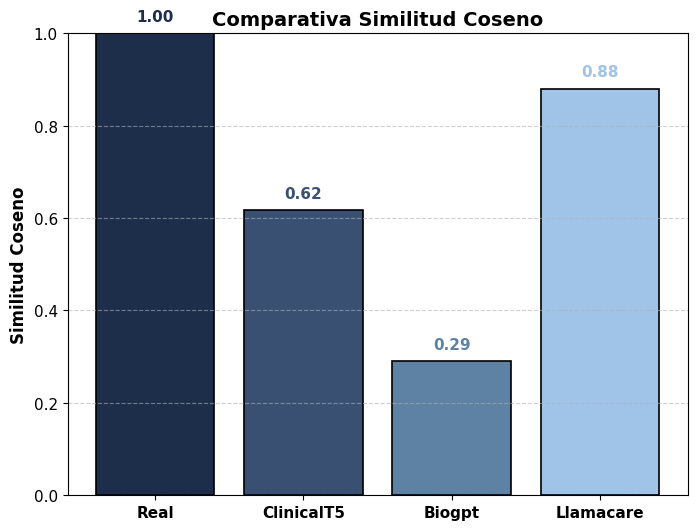

Modelo: clinicalt5, Similitud Coseno: 0.62
Modelo: biogpt, Similitud Coseno: 0.29
Modelo: llamacare, Similitud Coseno: 0.88


{'clinicalt5': 0.6164740349187038,
 'biogpt': 0.29043229145617083,
 'llamacare': 0.880341197345809}

In [27]:
evaluate_and_plot_similarities(prompt, generated_texts)

In [28]:
# Inicializar el modelo de embeddings de frases
model = SentenceTransformer('all-MiniLM-L6-v2')

# Calcular similitudes de coseno para cada modelo
similarities_clinicalt5 = compute_cosine_similarities(prompt, text_generate_t5)
similarities_biogpt = compute_cosine_similarities(prompt, text_generate_gpt)
similarities_llamacare = compute_cosine_similarities(prompt, text_generate_llama)

# Crear un DataFrame con las métricas estadísticas
similarity_metrics = pd.DataFrame({
    "Metric": ["mean", "std", "25%", "50%", "75%", "max"],
    "ClinicalT5": [
        np.mean(similarities_clinicalt5),
        np.std(similarities_clinicalt5),
        np.percentile(similarities_clinicalt5, 25),
        np.percentile(similarities_clinicalt5, 50),
        np.percentile(similarities_clinicalt5, 75),
        np.max(similarities_clinicalt5),
    ],
    "BioGPT": [
        np.mean(similarities_biogpt),
        np.std(similarities_biogpt),
        np.percentile(similarities_biogpt, 25),
        np.percentile(similarities_biogpt, 50),
        np.percentile(similarities_biogpt, 75),
        np.max(similarities_biogpt),
    ],
    "LlamaCare": [
        np.mean(similarities_llamacare),
        np.std(similarities_llamacare),
        np.percentile(similarities_llamacare, 25),
        np.percentile(similarities_llamacare, 50),
        np.percentile(similarities_llamacare, 75),
        np.max(similarities_llamacare),
    ],
})

display(similarity_metrics)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,Metric,ClinicalT5,BioGPT,LlamaCare
0,mean,0.643229,0.424479,0.825521
1,std,0.760555,0.901113,0.557407
2,25%,1.000000,-1.000000,1.000000
3,50%,1.000000,1.000000,1.000000
4,75%,1.000000,1.000000,1.000000
5,max,1.000000,1.000000,1.000000


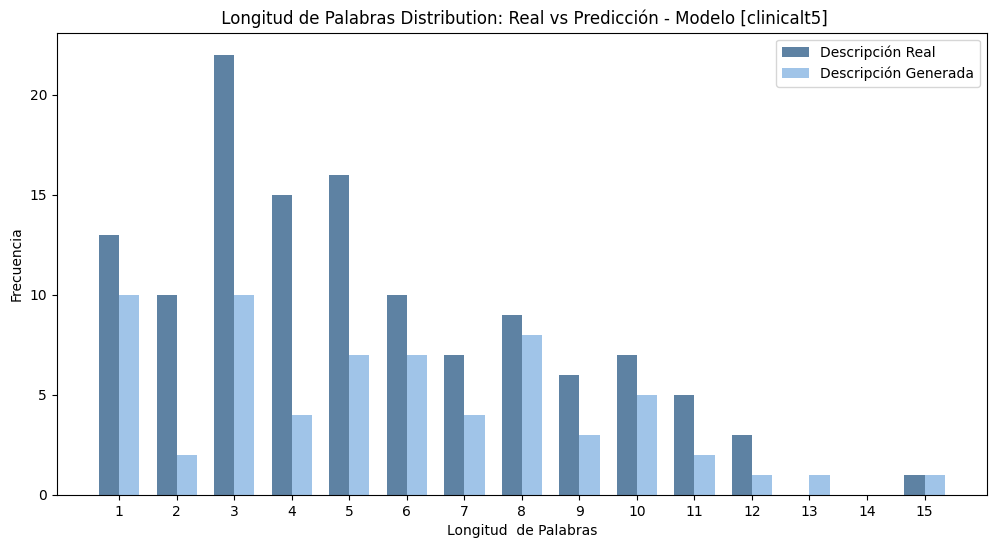

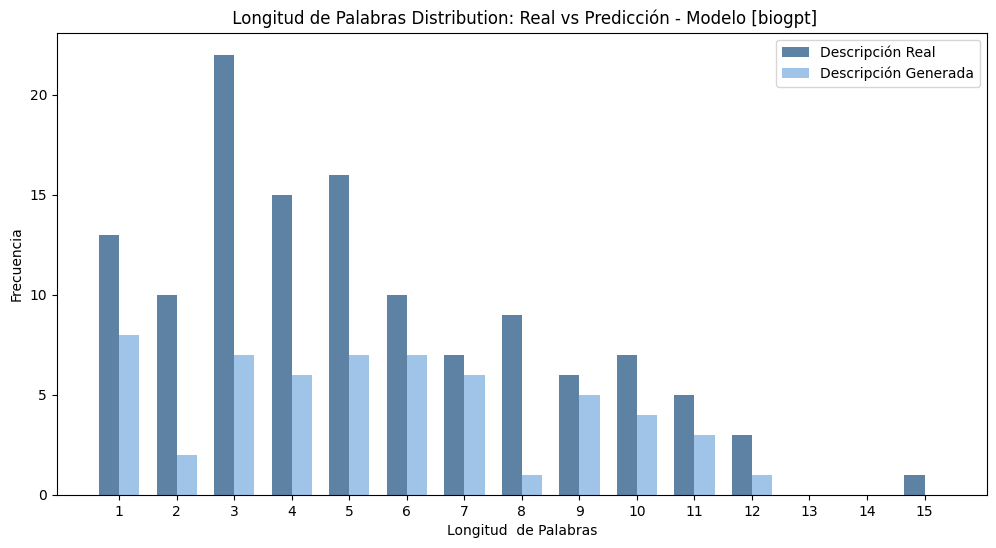

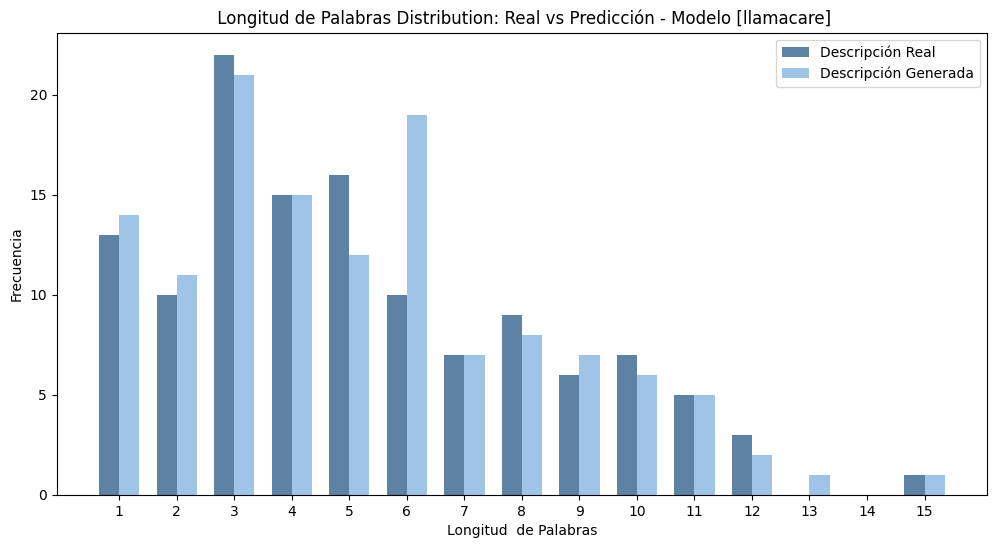

In [31]:
'''
# Calculate and print cosine similarity for each generated description
similarities = {model: calculate_similarity(prompt, text) for model, text in generated_texts.items()}

for model, similarity in similarities.items():
    print(f"Similitud Coseno entre lo real y lo generado : {similarity:.2f}")

print()
# Generate individual plots for each model
for model_name, score in similarities.items():
    print('')
    plot_individual_similarity(model_name, score)

print()
'''

# Generate word length distributions for each model and real text
real_word_lengths = word_length_distribution(prompt)
for model_name, text in generated_texts.items():
    print('')
    model_word_lengths = word_length_distribution(text)
    plot_grouped_bar_distribution(model_name, real_word_lengths, model_word_lengths)




